<a href="https://colab.research.google.com/github/ProKelly/micrograd/blob/master/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
def f(x):
  return 3*x**2 - 4*x + 5

In [20]:
f(3.0)

20.0

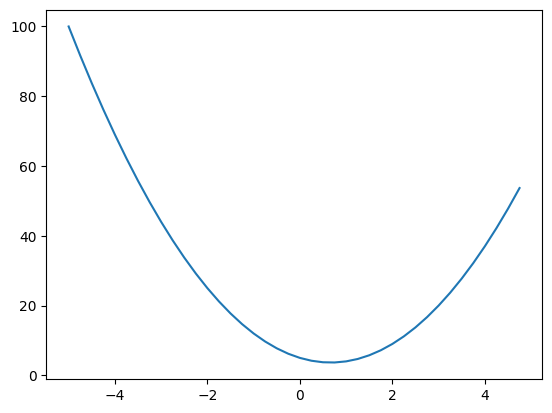

In [21]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [ ]:
h = 0.00001
x = 3.0
(f(x+h) - f(x))/h

14.00003000000538

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope ', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope  -3.000000000010772


Let's start building our data structure

In [6]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data = {self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward # just storing the function, can't call now because it returns None.

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    other = other.data if isinstance(other, Value) else other
    assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other-1)) * out.grad
    out._backward = _backward
    return out

  def __radd__(self, other): # other + self
        return self + other

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __rtruediv__(self, other): # other / self
    return other * self**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __rsub__(self, other): # other - self
        return other + (-self)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self): # automatic backpropagation
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0


    for node in reversed(topo):
      node._backward()

In [10]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'

d = e + c; d.label = 'd' #(a.__mul__(b)).__add__(c)
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data = -8.0)

In [11]:
d._prev

{Value(data = -6.0), Value(data = 10.0)}

In [12]:
d._op

'+'

In [13]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
      # Check if v is a Value object before adding it to nodes
      if isinstance(v, Value) and v not in nodes:
        nodes.add(v)
        for child in v._prev:
          edges.add((child, v))
          build(child)
      # If v is a list, iterate over its elements (which should be Value objects)
      elif isinstance(v, list):
          for item in v:
              build(item)

  # Call build with the root node to start the traversal
  build(root)
  # Return the nodes and edges collected during the traversal
  return nodes, edges # Added this return statement

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular {'record'} node for it
    dot.node(name= uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

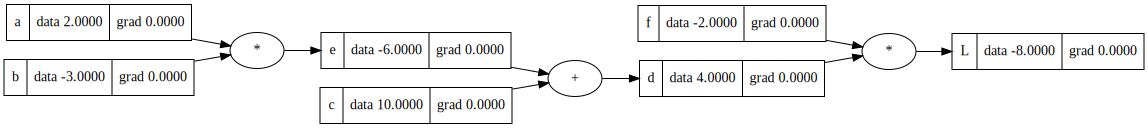

In [14]:
draw_dot(L)

In [15]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = d * f
L.data

-8.0

In [16]:
def lol():
  h = 0.001
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  a.data += h
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()


6.000000000000227


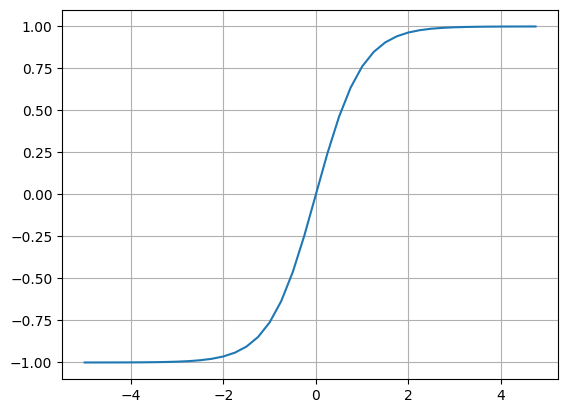

In [22]:
# activation function

x = np.arange(-5, 5, 0.25)
y = np.tanh(x)

plt.plot(x, y)
plt.grid()
plt.show()

In [23]:
#inputs

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()



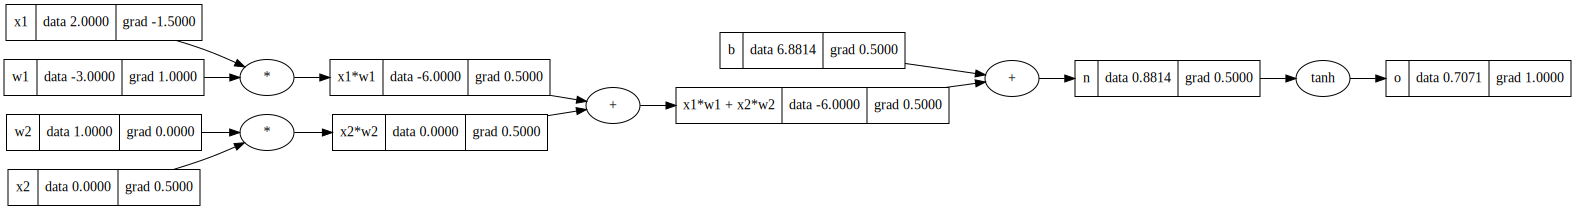

In [24]:
draw_dot(o)

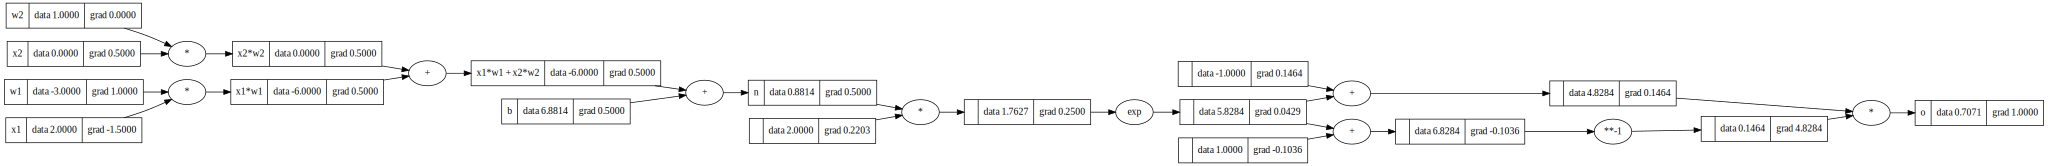

In [25]:
#inputs

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#----
e = (2*n).exp()
o = (e - 1) / (e + 1)
#-----
o.label = 'o'
o.backward()
draw_dot(o)



In [26]:
o.backward()

In [27]:
# top logical sort
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo


[Value(data = 1),
 Value(data = -3.0),
 Value(data = 2.0),
 Value(data = -6.0),
 Value(data = 1.0),
 Value(data = 0.0),
 Value(data = 0.0),
 Value(data = -6.0),
 Value(data = 6.881373587019543),
 Value(data = 0.8813735870195432),
 Value(data = 2),
 Value(data = 1.7627471740390863),
 Value(data = 5.828427124746192),
 Value(data = 6.828427124746192),
 Value(data = 0.1464466094067262),
 Value(data = -1),
 Value(data = 4.828427124746192),
 Value(data = 0.7071067811865477)]

In [28]:
o.grad = 1.0

In [29]:
o._backward()

In [30]:
n._backward()

In [31]:
b._backward()

In [32]:
x1w1x2w2._backward()

In [33]:
x2w2._backward()
x1w1._backward()

**Manual Back propagation**

In [34]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [35]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [36]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [37]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [38]:
n.grad = 0.5

In [39]:
o.grad = 1.0

In [40]:
1 - o.data**2

0.4999999999999998

In [41]:
# o = tanh(n)
# do/dn = 1 - o**2

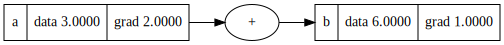

In [42]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [43]:
a = Value(2.0)
b = Value(3.0)
a**b

Value(data = 8.0)

Using a modern Libary to implement thesame thing i.e Micrograd using **pytorch**


In [44]:
import torch
import random

In [45]:

x1 = torch.Tensor([2.0]).double()                      ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                      ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                     ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                      ;w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()        ;b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Building 2 layer multilinear perceptron neural network

In [46]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [47]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = -0.6391263804527508)

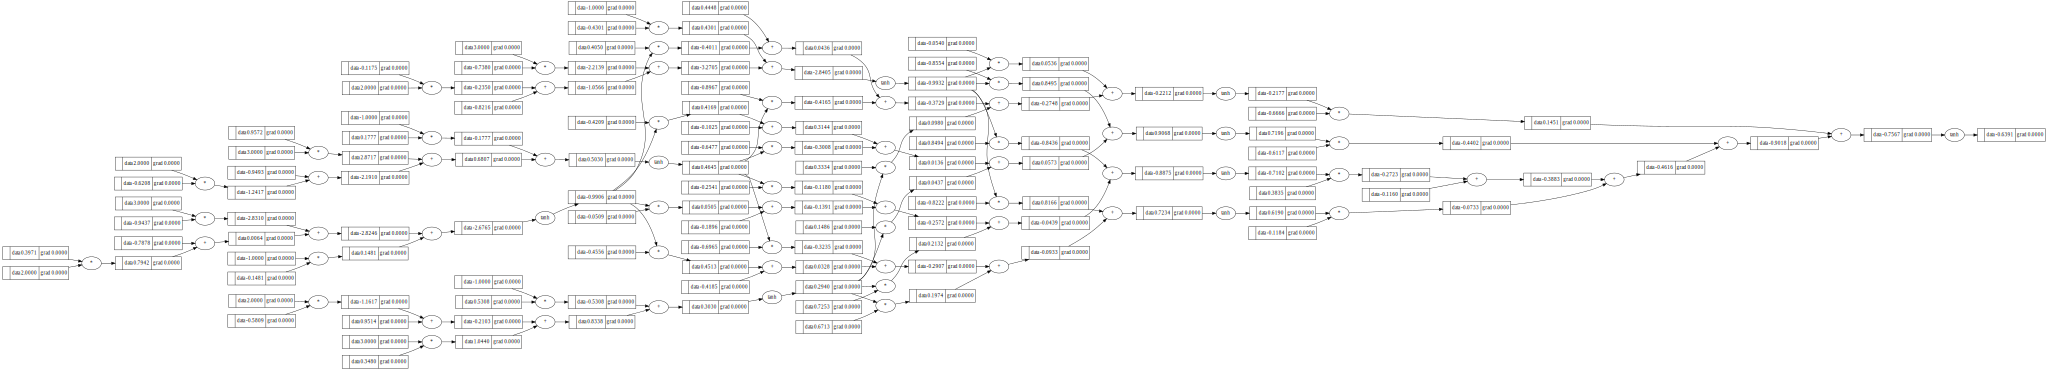

In [48]:
draw_dot(n(x))

In [49]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [50]:
# mean squared error loss
for k in range(20):

  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

0 6.291472509599058
1 4.002703911948109
2 2.534866431801316
3 1.7369456804353898
4 1.087032645423125
5 0.6667939012263688
6 0.4407094872042979
7 0.31704760987800024
8 0.2430240524004039
9 0.19492058927619932
10 0.1615963017991008
11 0.1373443391862424
12 0.1190037743846718
13 0.10470400916836707
14 0.09327583628541126
15 0.08395465477448905
16 0.07622124059168371
17 0.06971160693591658
18 0.06416357839403435
19 0.05938385040291874


In [51]:
ypred

[Value(data = 0.9293652999836024),
 Value(data = -0.8653821020266657),
 Value(data = -0.8724355788537262),
 Value(data = 0.8585788928081479)]

In [52]:
loss.backward()

In [53]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [54]:
ypred

[Value(data = 0.9293652999836024),
 Value(data = -0.8653821020266657),
 Value(data = -0.8724355788537262),
 Value(data = 0.8585788928081479)]

In [55]:
n.parameters()

[Value(data = 0.3731551514058621),
 Value(data = -0.9584143185790077),
 Value(data = -0.09395858714078607),
 Value(data = -0.8019604590922181),
 Value(data = -0.2623225482146131),
 Value(data = 1.2104081876123167),
 Value(data = -0.6495291076324153),
 Value(data = -0.8422773097580075),
 Value(data = -0.7365620990832458),
 Value(data = 0.11274085014559397),
 Value(data = 0.7435812106787192),
 Value(data = 0.8203792267328535),
 Value(data = -0.16413749420464774),
 Value(data = -0.6408174024694067),
 Value(data = -0.5162107598370342),
 Value(data = -0.8009998122510035),
 Value(data = -0.08924670867453773),
 Value(data = -0.24510704082864468),
 Value(data = 0.6982535500493935),
 Value(data = 0.8188712526243023),
 Value(data = -0.15393958455089923),
 Value(data = -0.41630202451661985),
 Value(data = -0.7297684221117693),
 Value(data = 0.6698037200939333),
 Value(data = -0.8057571162451586),
 Value(data = -0.43426134266050614),
 Value(data = -0.1627631213690875),
 Value(data = -0.86969844491